# Install and import requirements

In [ ]:
%cd /content/drive/MyDrive/Github/Idoven
!pip install -qq -U -r requirements.txt
import numpy
import pandas
import ast
import matplotlib.pyplot
import seaborn
import ecg_plot
import utils

/content/drive/MyDrive/Github/Idoven
     |████████████████████████████████| 13.1 MB 6.3 MB/s 
     |████████████████████████████████| 288 kB 51.3 MB/s 
     |████████████████████████████████| 161 kB 45.5 MB/s 
     |████████████████████████████████| 137 kB 51.3 MB/s 
     |████████████████████████████████| 137 kB 57.4 MB/s 


# Configure some parameters

In [ ]:
path = 'physionet.org/files/ptb-xl/1.0.2/'
%matplotlib inline
seaborn.set(style='whitegrid', palette='Set2', font_scale=1.5)
matplotlib.pyplot.rcParams['figure.figsize'] = (10, 5)
matplotlib.pyplot.rcParams['figure.dpi'] = 100

# Identify whether a normal 12-lead ECG-waveform can be differentiated

## Data

In [ ]:
data_ptbxl = pandas.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
data_ptbxl.r_peaks = data_ptbxl.r_peaks.apply(lambda x: list(map(int, x.replace('[', '').replace(']', '').split())))
data_ptbxl.scp_codes = data_ptbxl.scp_codes.apply(lambda x: ast.literal_eval(x))
data_scp = pandas.read_csv(path + 'scp_statements.csv', index_col=0)
data_scp = data_scp[data_scp.diagnostic == 1]
data_ptbxl['diagnostic_superclass'] = data_ptbxl.scp_codes.apply(lambda x: utils.aggregate_superclasses(x, data_scp))
data_ptbxl['heart_rate'] = data_ptbxl.r_peaks.apply(utils.aggregate_heart_rate)
data_ptbxl['rr_interval_variability'] = data_ptbxl.r_peaks.apply(utils.aggregate_RR_interval_variability)
data_ptbxl = (data_ptbxl
              .replace({'sex': {1: 'Female', 0: 'Male'}})
              .loc[data_ptbxl.diagnostic_superclass.apply(len) != 0, :]
              .explode(['diagnostic_superclass'])
              )
data_ptbxl['binary_diagnostic_superclass'] = (data_ptbxl.diagnostic_superclass
.apply(lambda x: 'ANOMALY' if x in ['CD', 'HYP', 'MI', 'STTC'] else 'NORMAL'))

## Diagnostic superclasses stats 

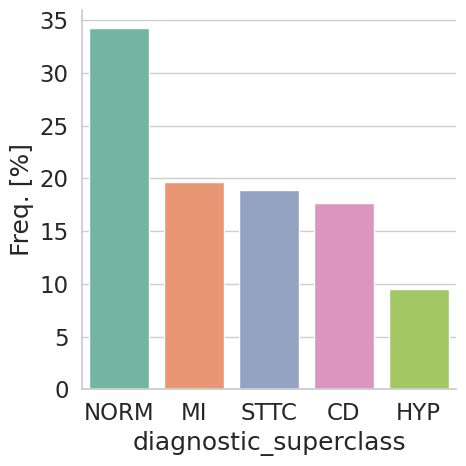

In [ ]:
(data_ptbxl
.diagnostic_superclass
.value_counts(normalize=True)
.mul(100)
.rename('Freq. [%]')
.rename_axis('diagnostic_superclass')
.reset_index()
.pipe((seaborn.catplot, 'data'), x='diagnostic_superclass', y='Freq. [%]', kind='bar'));

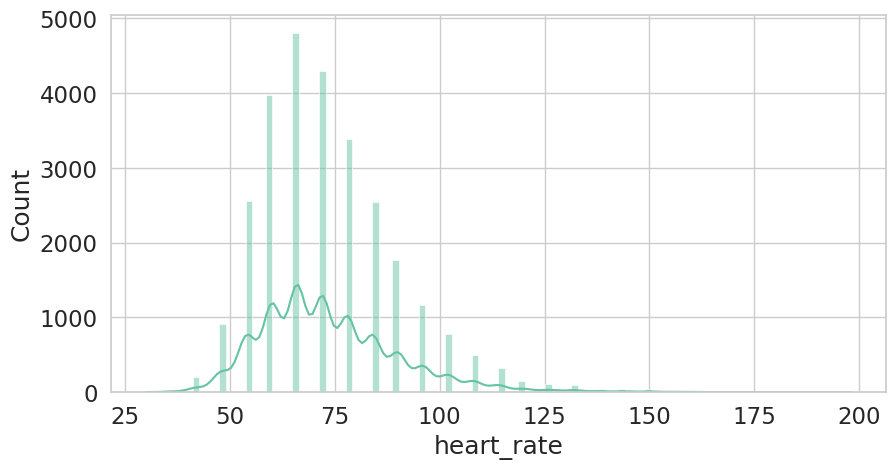

In [ ]:
seaborn.histplot(data=data_ptbxl, x="heart_rate", kde=True);

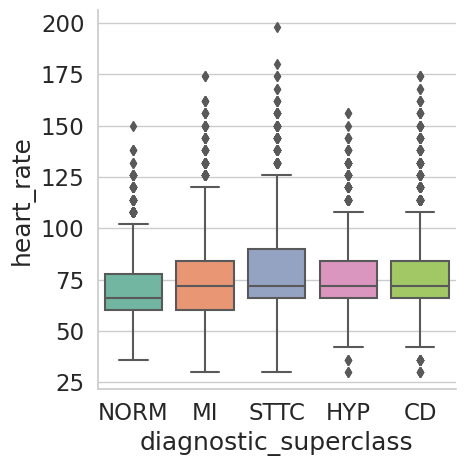

In [ ]:
seaborn.catplot(data=data_ptbxl, y="heart_rate", x='diagnostic_superclass', kind='box');

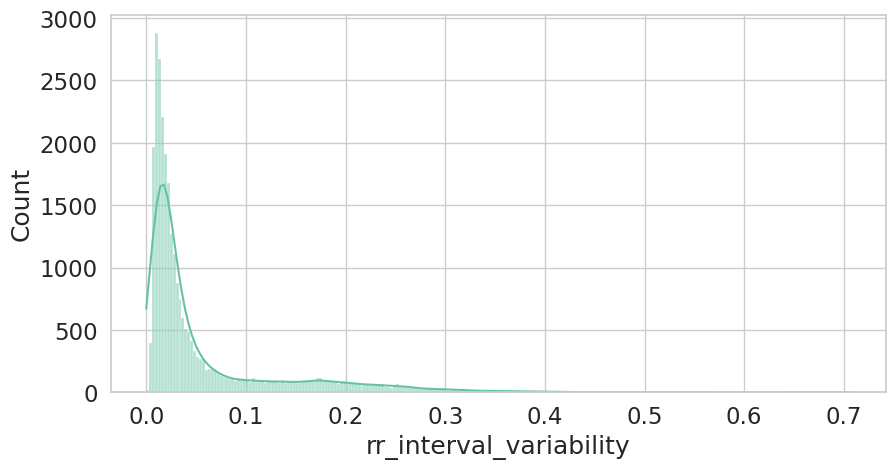

In [ ]:
seaborn.histplot(data=data_ptbxl, x="rr_interval_variability", kde=True);

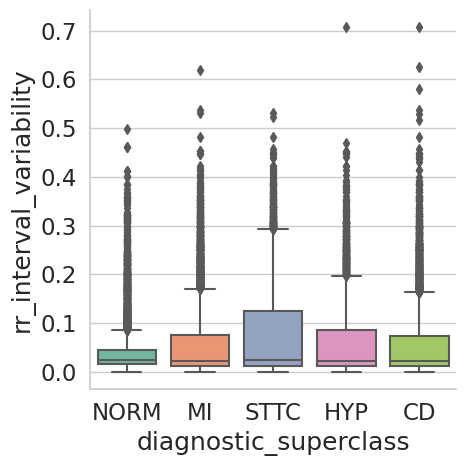

In [ ]:
seaborn.catplot(data=data_ptbxl, y="rr_interval_variability", x='diagnostic_superclass', kind='box');

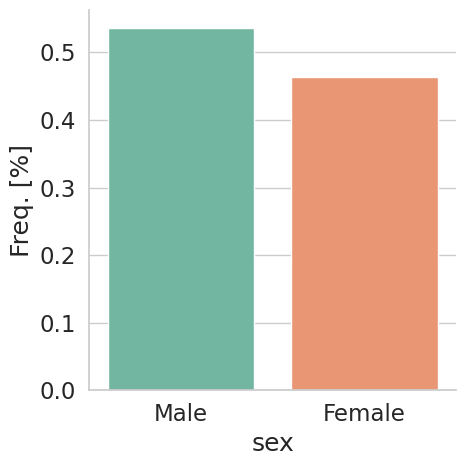

In [ ]:
(data_ptbxl
.sex
.value_counts(normalize=True)
.rename('Freq. [%]')
.rename_axis('sex')
.reset_index()
.pipe((seaborn.catplot, 'data'), x='sex', y='Freq. [%]', kind='bar'));

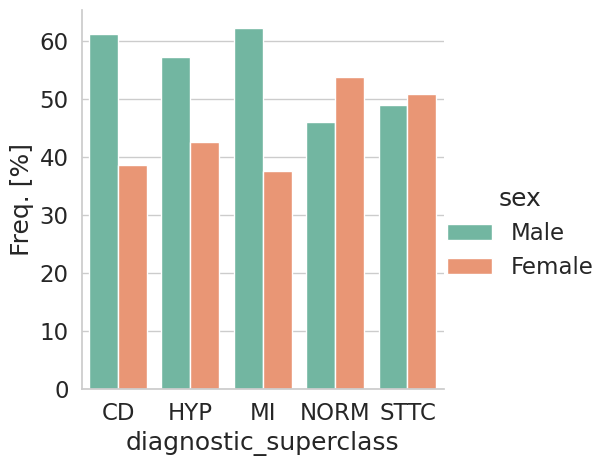

In [ ]:
(data_ptbxl
.groupby('diagnostic_superclass')['sex']
.value_counts(normalize=True)
.mul(100)
.rename('Freq. [%]')
.reset_index()
.pipe((seaborn.catplot, 'data'), x='diagnostic_superclass', y='Freq. [%]', hue='sex', kind='bar'));

## Evaluation of ECGs: NORMAL versus ANOMALY 

In [ ]:
mode = 'test'
superclass = 'NORMAL'
number_ECGs = 100 
# data=data_ptbxl, n=number_ECGs are only neccesary if ECGs need to be extracted
ECG_test_NORMAL = utils.load_ECGs(mode=mode, superclass=superclass, data=data_ptbxl, n=number_ECGs)
ECG_test_NORMAL.shape

(100, 1000, 12)

In [ ]:
leads = ['I', 'aVR', 'V1', 'V4', 'II', 'aVL', 'V2', 'V5', 'III', 'aVF', 'V3', 'V6']

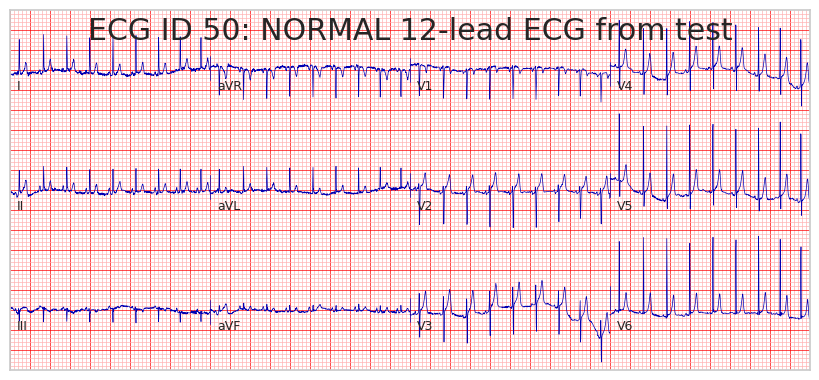

In [ ]:
random_ecg_id = numpy.random.choice(range(ECG_test_NORMAL.shape[0]))
ecg_plot.plot(
    numpy.transpose(ECG_test_NORMAL[random_ecg_id, :, :]), 
    title=f'ECG ID {random_ecg_id + 1}: {superclass} 12-lead ECG from {mode}', 
    columns=4
    )
figure = matplotlib.pyplot.gca()
for xticklabel in figure.axes.get_xticklabels():
  xticklabel.set_visible(False)
for yticklabel in figure.axes.get_yticklabels():
  yticklabel.set_visible(False)

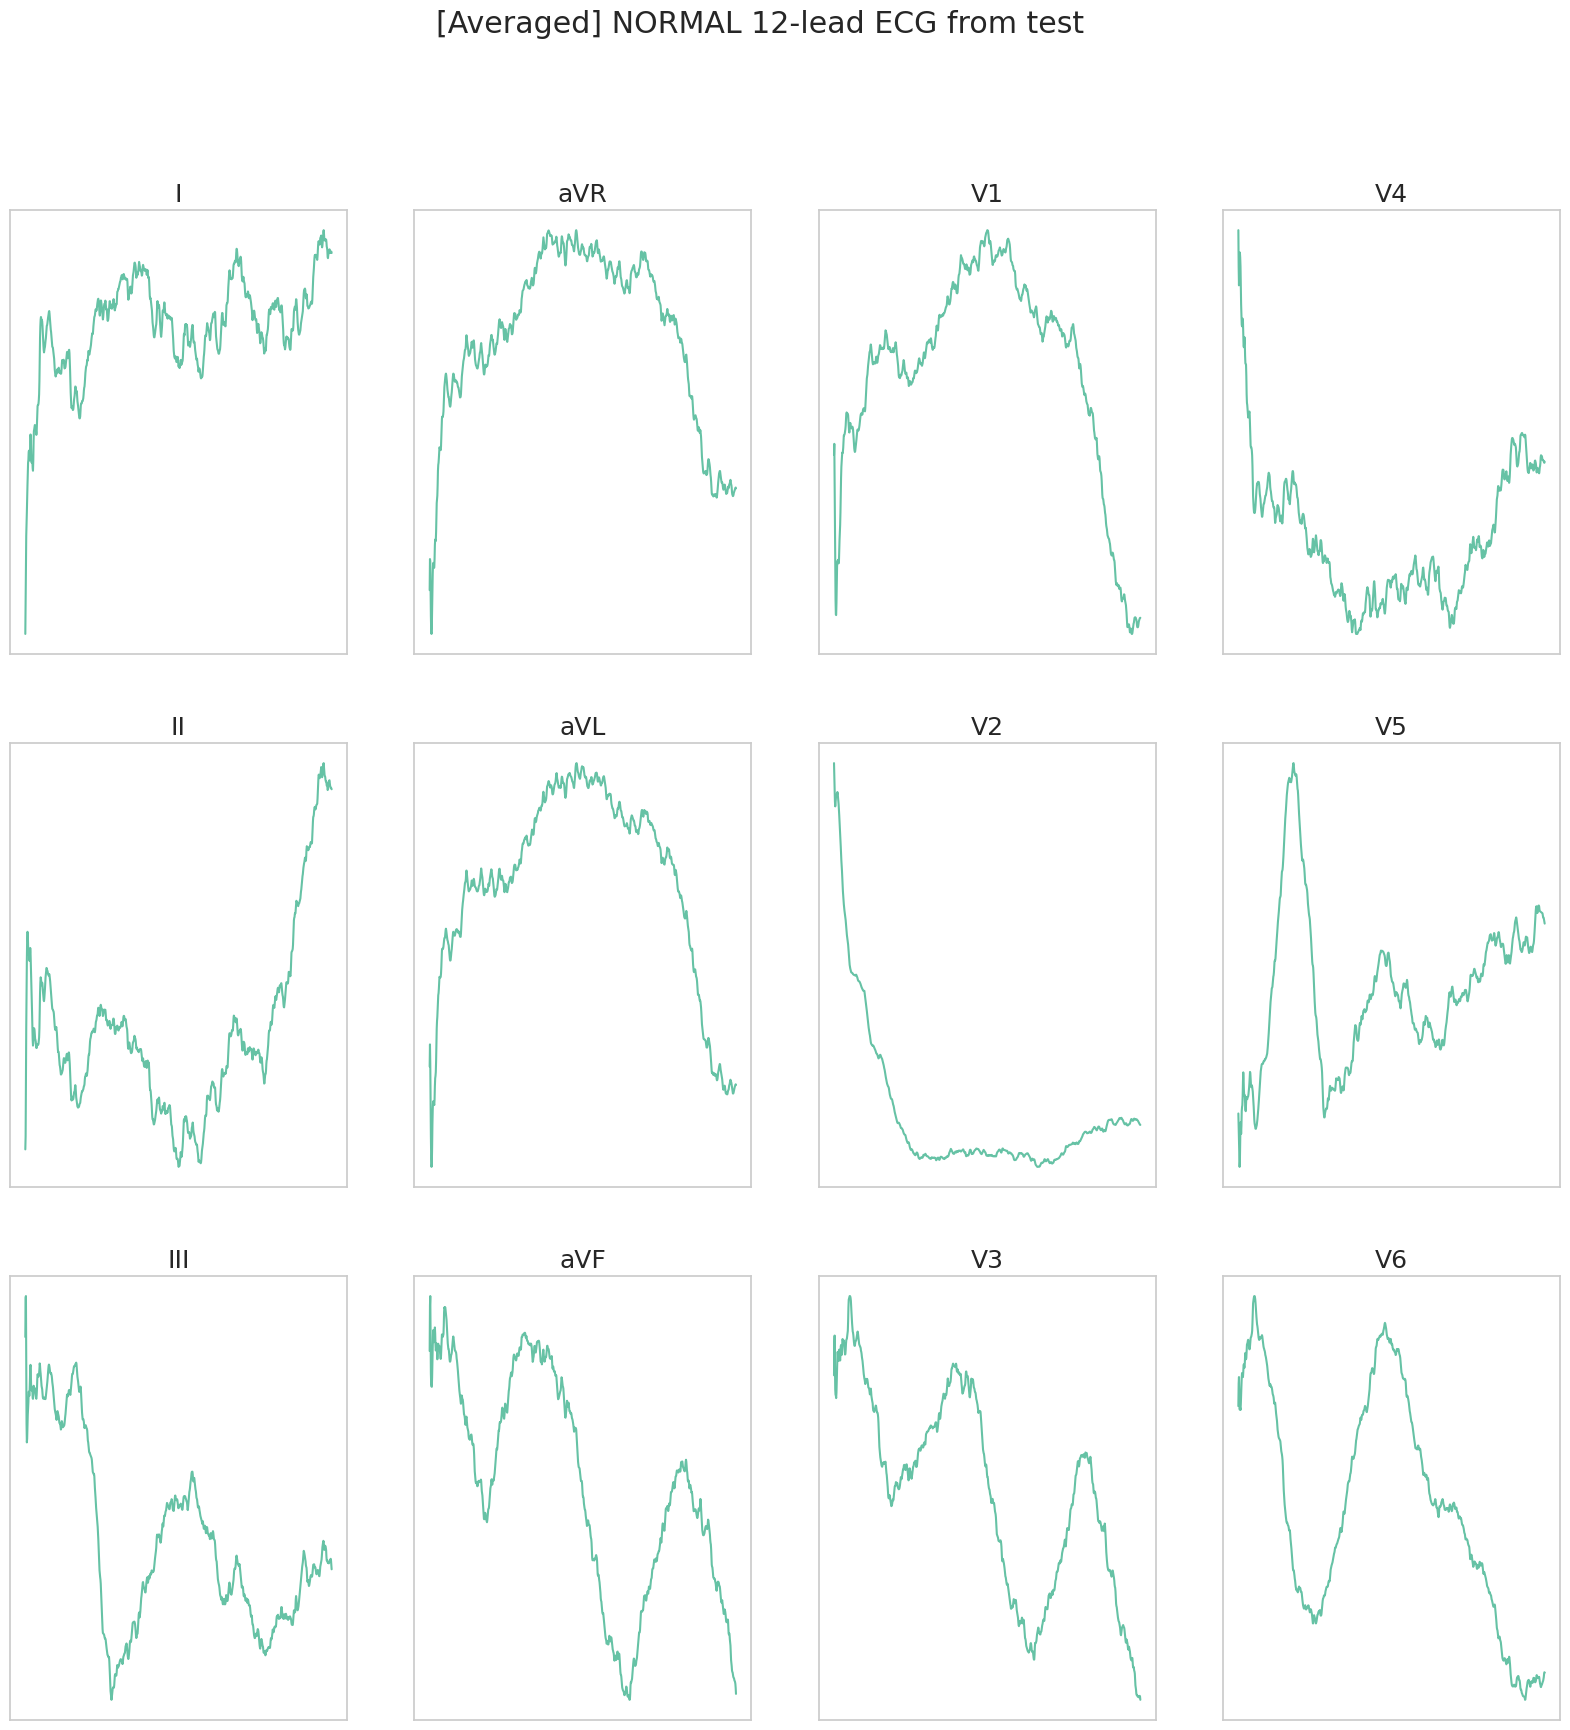

In [ ]:
nrows, ncols = 3, 4
figure, axes = matplotlib.pyplot.subplots(nrows, ncols, figsize=(20, 20))
figure.suptitle(f'[Averaged] {superclass} 12-lead ECG from {mode}')

for i in range(nrows*ncols):
  axes.flatten()[i].plot(
      (pandas.DataFrame(ECG_test_NORMAL[:, :, i].mean(axis=0))
      .rolling(100, axis=0, min_periods=1)
      .mean())
      )
  axes.flatten()[i].set_title(f'{leads[i]}')
  axes.flatten()[i].set_xticks([])
  axes.flatten()[i].set_yticks([])

In [ ]:
mode = 'test'
superclass = 'ANOMALY'
number_ECGs = 100
# data=data_ptbxl, n=number_ECGs are only neccesary if ECGs need to be extracted
ECG_test_ANOMALY = utils.load_ECGs(mode=mode, superclass=superclass, data=data_ptbxl, n=number_ECGs)
ECG_test_ANOMALY.shape

(100, 1000, 12)

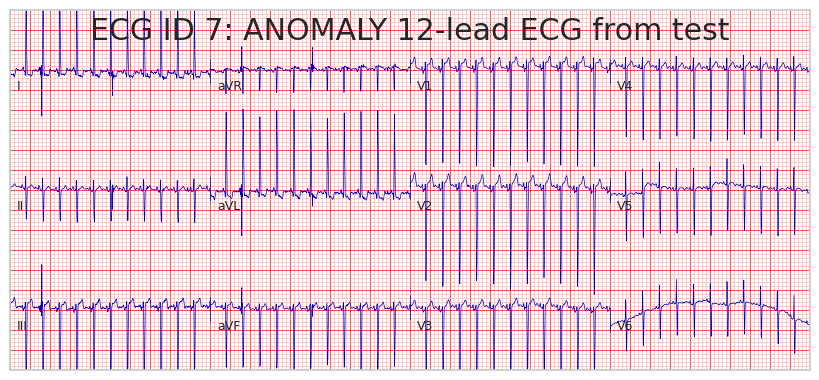

In [ ]:
random_ecg_id = numpy.random.choice(range(ECG_test_ANOMALY.shape[0]))
ecg_plot.plot(
    numpy.transpose(ECG_test_ANOMALY[random_ecg_id, :, :]), 
    title=f'ECG ID {random_ecg_id + 1}: {superclass} 12-lead ECG from {mode}',
    columns=4
    )
figure = matplotlib.pyplot.gca()
for xticklabel in figure.axes.get_xticklabels():
  xticklabel.set_visible(False)
for yticklabel in figure.axes.get_yticklabels():
  yticklabel.set_visible(False)

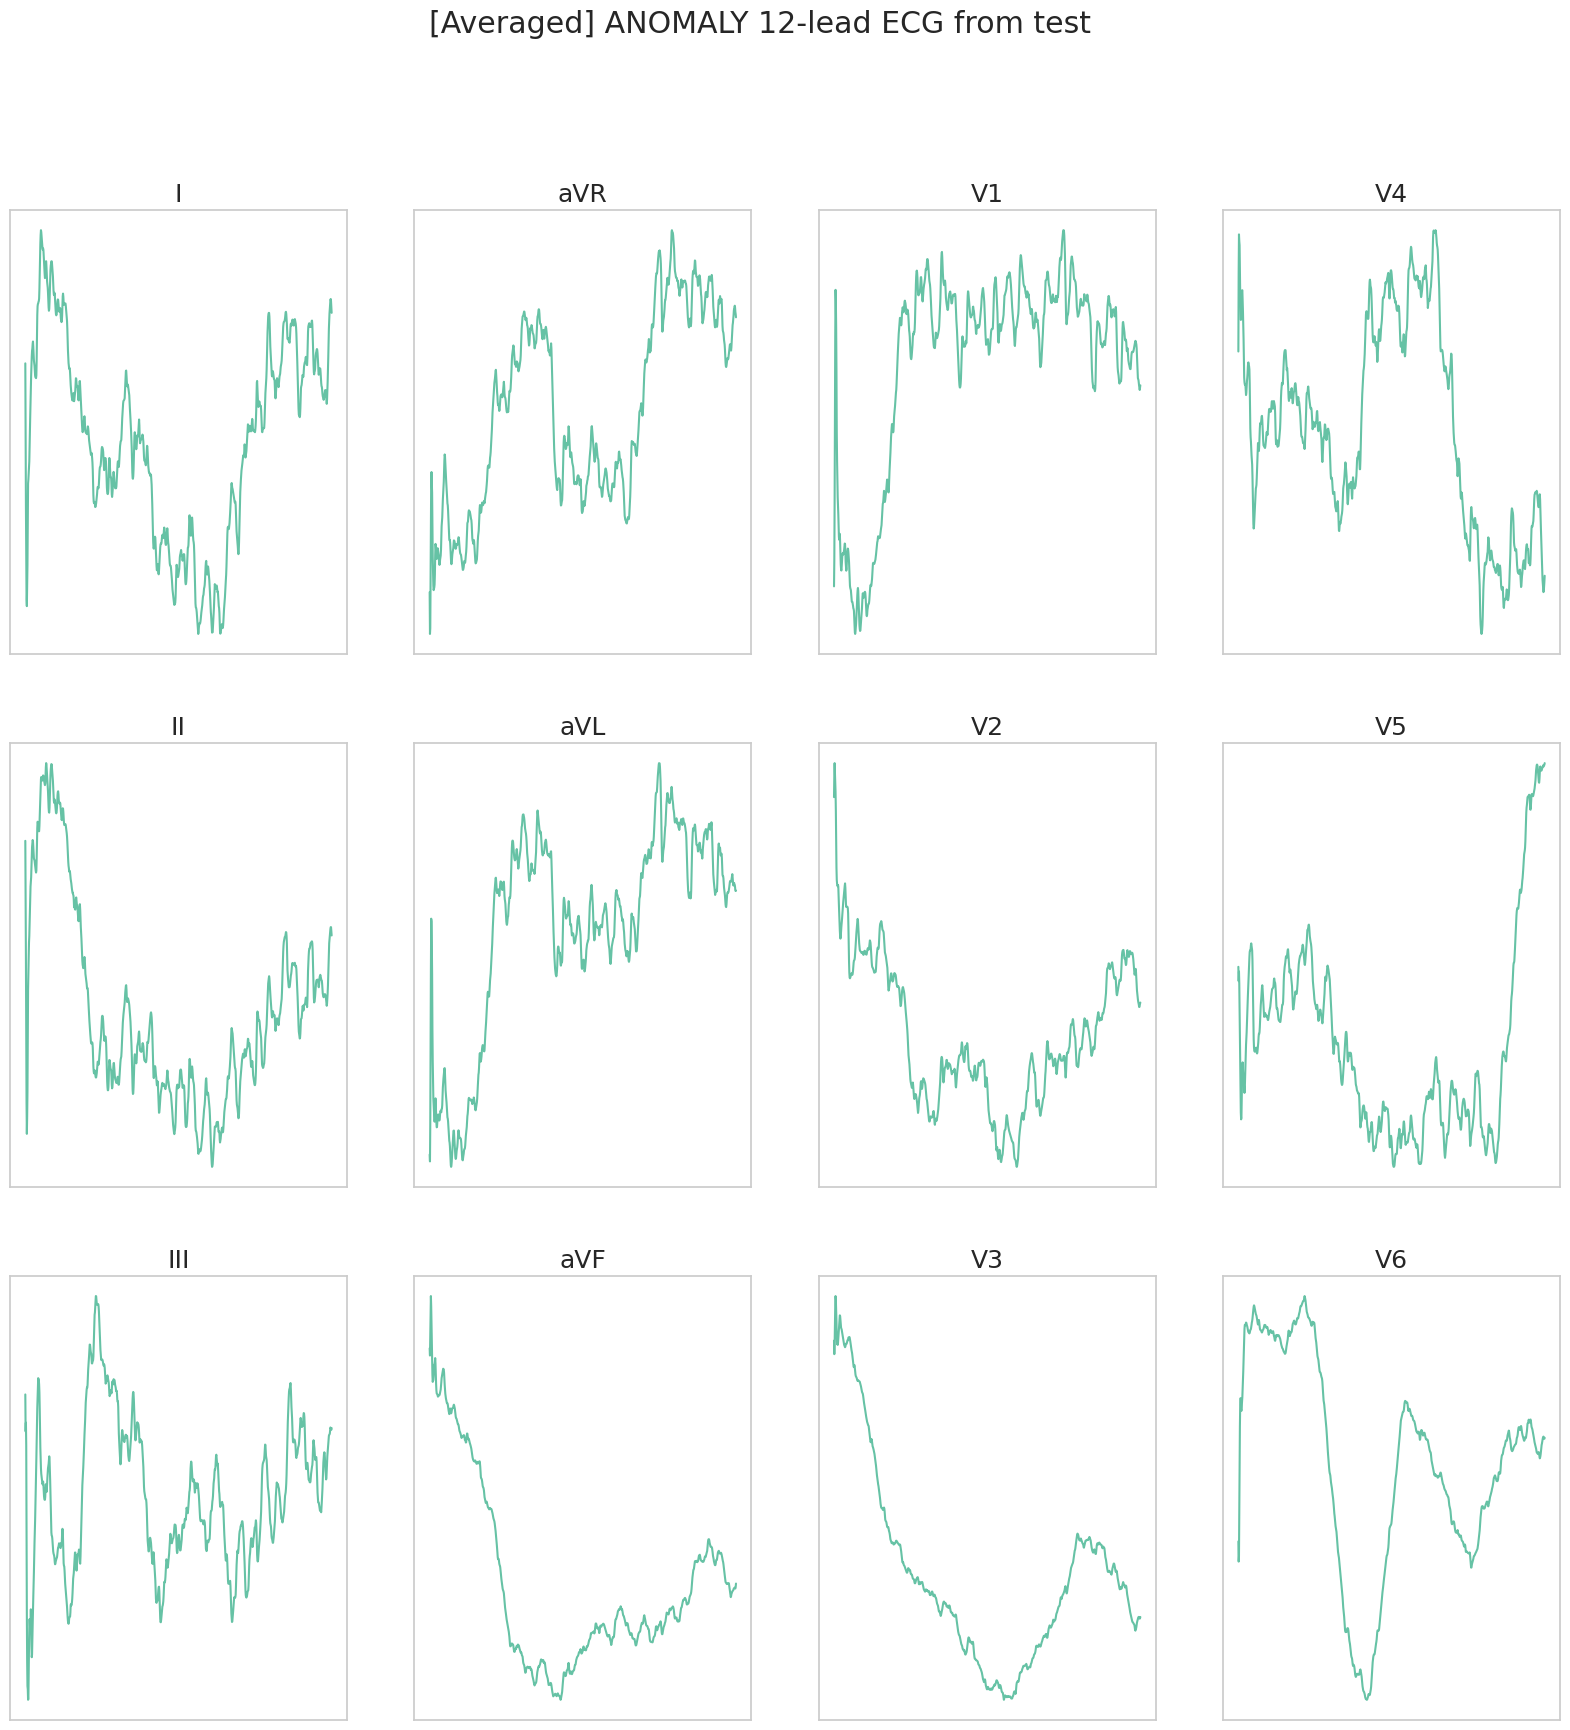

In [ ]:
nrows, ncols = 3, 4
figure, axes = matplotlib.pyplot.subplots(nrows, ncols, figsize=(20, 20))
figure.suptitle(f'[Averaged] {superclass} 12-lead ECG from {mode}')

for i in range(nrows*ncols):
  axes.flatten()[i].plot(
      (pandas.DataFrame(ECG_test_ANOMALY[:, :, i].mean(axis=0))
      .rolling(100, axis=0, min_periods=1)
      .mean())
      )
  axes.flatten()[i].set_title(f'{leads[i]}')
  axes.flatten()[i].set_xticks([])
  axes.flatten()[i].set_yticks([])

## Conclusion
It looks like there are distinctly different patterns between NORMAL and ANOMALY. So, it makes sense to create a model that allows alerting whether a 12-lead ECG-waveform is deviated from normal behavior.